# Introduction

This is an example notebook for testing noise filtering methods on Birds Dataset.
The focus is to start to explore some techniques of preprocessing that can be used to improve bird detection models.
The problem is that the Cornell Birdcall Identification Dataset have many sounds of low quality, with high level background sounds and noises. Thus, I believe that applying some filtering method for noise reduction can improve the classification task.

Common detection pipelines consist of:
* Preprocessing: To read a audio file, optionally apply signal filtering techniques, and perform feature extraction (e.g. mfccs);
* Trainning a classification model based on features (TO DO);
* Evaluation: To test the trainned models over a split of the dataset (TO DO).

The preprocess methods you can see here are:
* Traditional log mel-spectogram;
* High-Pass Filtering: Reduces low frequencies, once bird sound are commonly present on high frequencies;
* Per-channel energy normalization (PCEN): Technique for automatic gain control, followed by nonlinear compression;
* Spectral Gating: Common strategy for denoising music by gating the signal only on high level sounds.

Please, use this notebook as a didactical one. 
If you enjoy it, please, leave your upvote and comments.

Thanks!

# Imports

In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


# Preprocessing methods

## Reading some audio samples

Let's see some preprocessing techniques over the example_test_audio dataset.

In [2]:
sr = 16000
e_file1 = '../input/birdsong-recognition/example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.mp3'
e_file2 = '../input/birdsong-recognition/example_test_audio/ORANGE-7-CAP_20190606_093000.pt623.mp3'

# 10 seconds of each file
y1,sr = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)
y2,sr = librosa.load(e_file2, mono=True, sr=sr, offset=0, duration=10)

Listen to them!

In [3]:
from IPython.display import Audio, IFrame, display

display(Audio(y1,rate=sr))
display(Audio(y2,rate=sr))

As you can hear, the first audio presents a high level background noise, and birds seems far from the mic. In the second audio, bird sounds are much more distinguished from the other noises. We can say that the second audio presents a better SNR (signal-noise ratio).

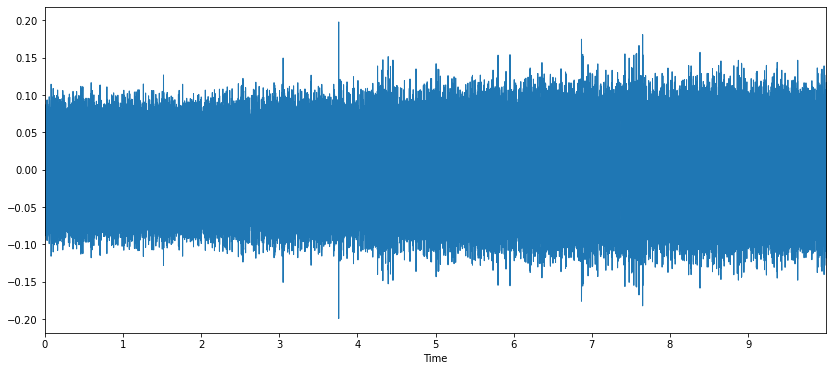

In [4]:
librosa.display.waveplot(y1,sr=sr, x_axis='time');

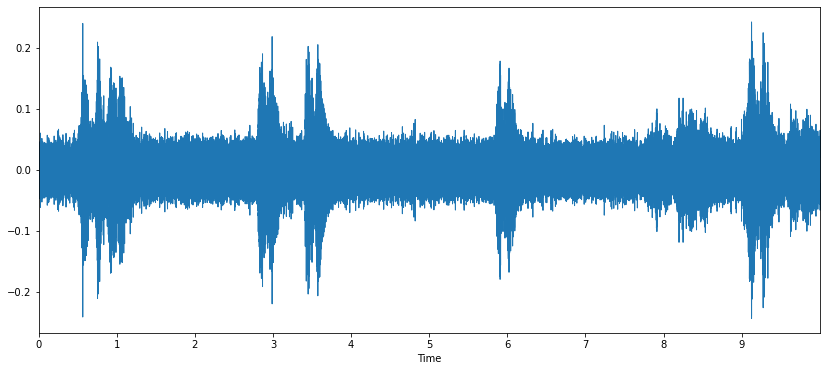

In [5]:
librosa.display.waveplot(y2,sr=sr, x_axis='time');

If you look to both signal waves, you can see that the first sound presents a lower difference between the background level and some sound events, while this difference is much higher in the second sound. If you do it in sync with the audio, we can see that some bird calls does not appear from the average sound level.

## Logmel-spectogram

A very common preprocessing technique in audio detection applications is to transform audios to its log mel-spectogram representation.
Some concepts here: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

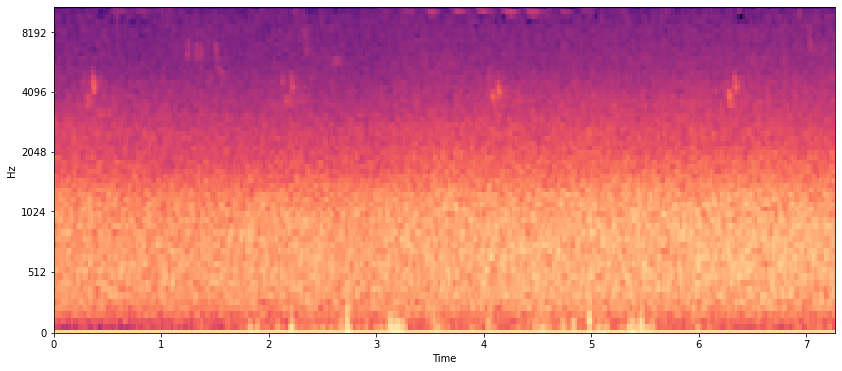

In [6]:
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

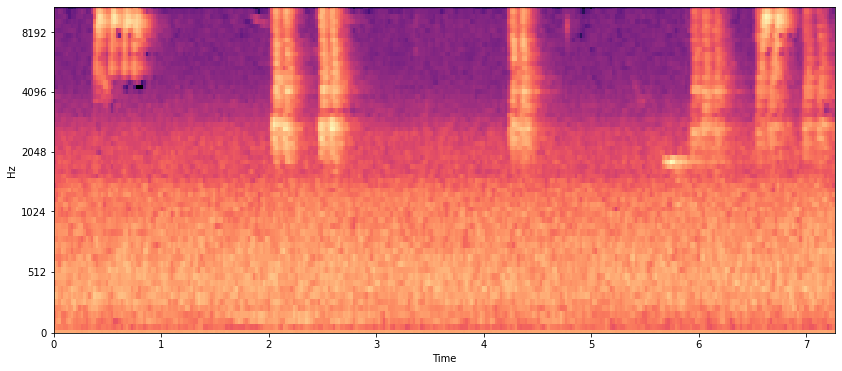

In [7]:
S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=64)
D2 = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(D2, x_axis='time', y_axis='mel');

The differences become very clear in the log mel spectogram. In the fist case, you can see a lot of artefacts on low frequencies (not birds), and the birds are in levels below the background noises. Besides, background noises are higher in frequencies below 2 kHz.

## Filtering low-frequencies

As we noticed, low frequencies does not contribute to bird sounds, a first idea is to remove these low frequencies. A high pass filter helps in this task. Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

In [8]:
from scipy import signal
import random


def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf


In [9]:
yf1 = f_high(y1, sr)
yf2 = f_high(y2, sr)

Let's see...

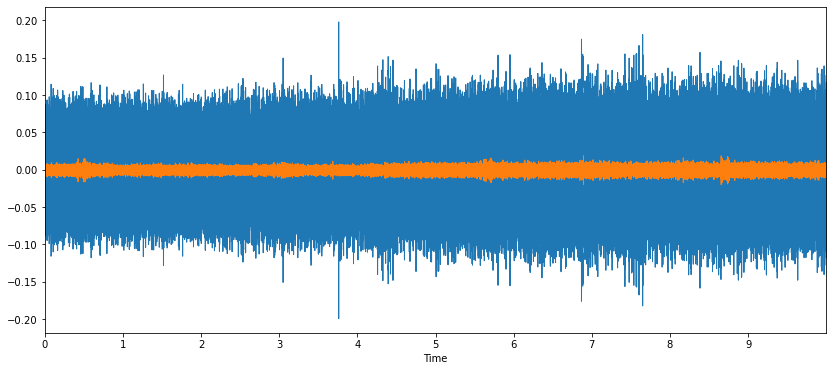

In [10]:
librosa.display.waveplot(y1,sr=sr, x_axis='time');
librosa.display.waveplot(yf1,sr=sr, x_axis='time');

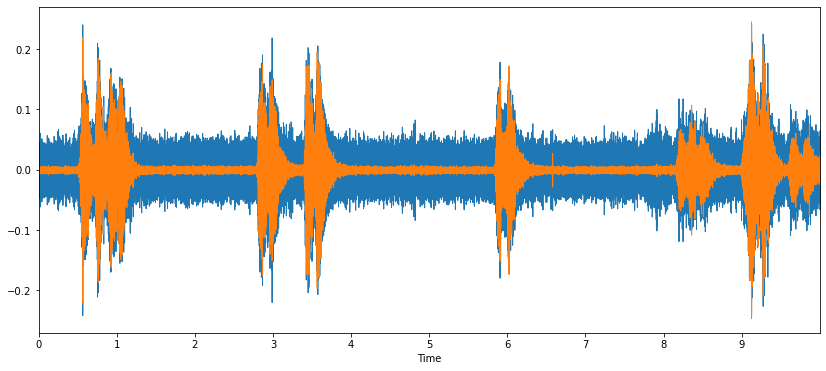

In [11]:
librosa.display.waveplot(y2,sr=sr, x_axis='time');
librosa.display.waveplot(yf2,sr=sr, x_axis='time');

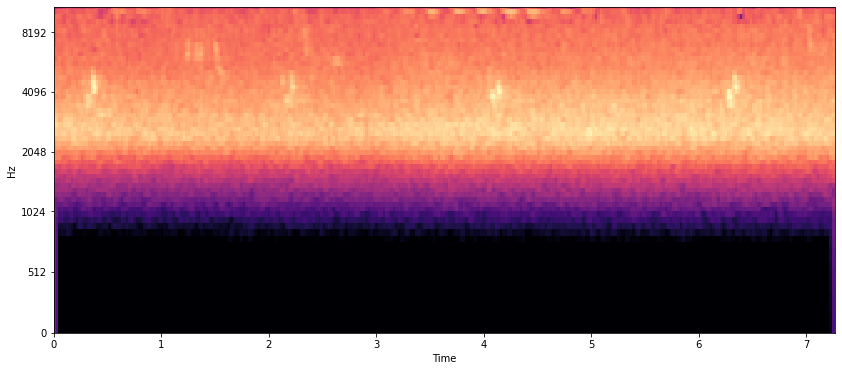

In [12]:
Sf1 = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=64)
Df1 = librosa.power_to_db(Sf1, ref=np.max)
librosa.display.specshow(Df1, x_axis='time', y_axis='mel');

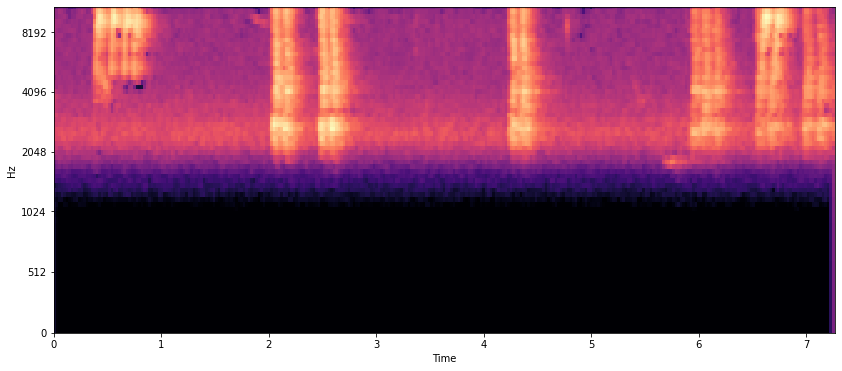

In [13]:
Sf2 = librosa.feature.melspectrogram(y=yf2, sr=sr, n_mels=64)
Df2 = librosa.power_to_db(Sf2, ref=np.max)
librosa.display.specshow(Df2, x_axis='time', y_axis='mel');

In [14]:
display(Audio(yf1,rate=sr))
display(Audio(yf2,rate=sr))

In both cases, the filter helped to isolate the interesting frequencies. The second audio is in a very good quality for distincting the birds. But the first audio also have high level noises in bird frequencies. Simply removing these frequencies can make us loose important information.

## PCEN

PCEN has become a very useful strategy for acoustic event detection, and it has shown to perform better in such tasks as a frontend. Its idea is to perform non-linear compression on time-frequency channels.

I am using the example shown here: https://librosa.org/doc/latest/generated/librosa.pcen.html?highlight=pcen#librosa.pcen

In [15]:
Dp1 = librosa.pcen(S1 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)
Dp2 = librosa.pcen(S2 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)

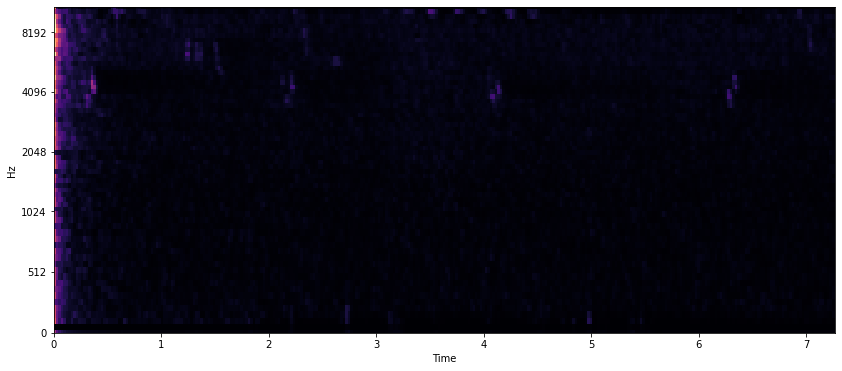

In [16]:
librosa.display.specshow(Dp1, x_axis='time', y_axis='mel');

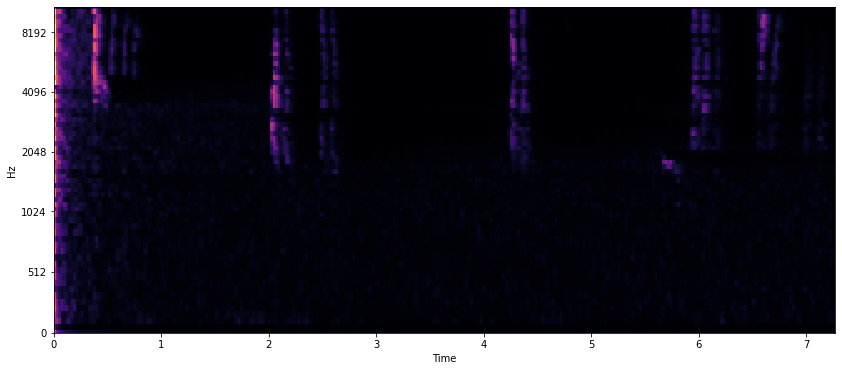

In [17]:
librosa.display.specshow(Dp2, x_axis='time', y_axis='mel');

In [18]:
yp1 = librosa.feature.inverse.mel_to_audio(Dp1)
yp2 = librosa.feature.inverse.mel_to_audio(Dp2)

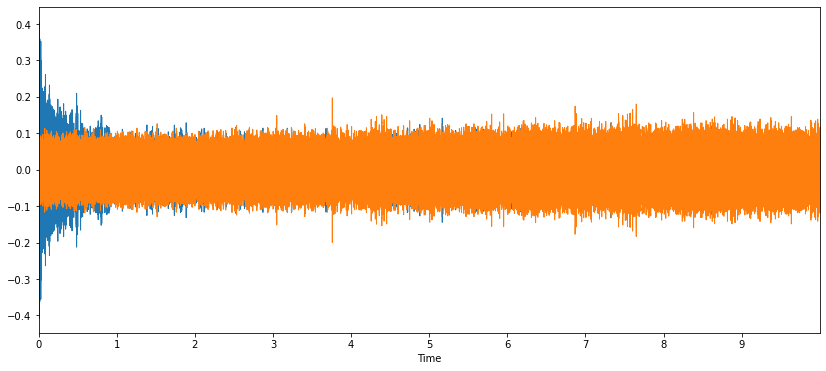

In [19]:
librosa.display.waveplot(yp1,sr=sr, x_axis='time');
librosa.display.waveplot(y1,sr=sr, x_axis='time');

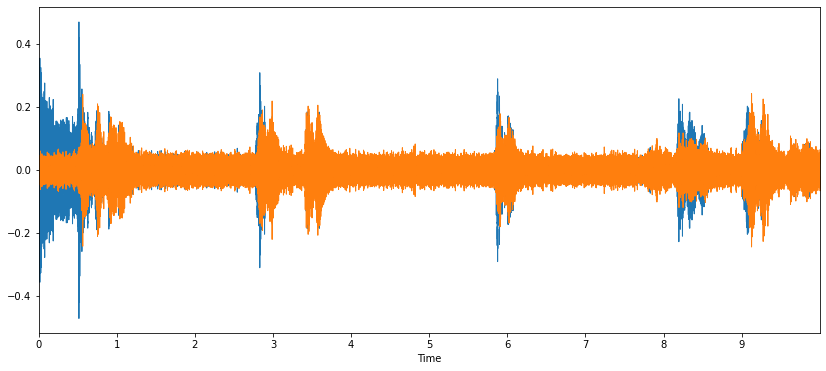

In [20]:
librosa.display.waveplot(yp2,sr=sr, x_axis='time');
librosa.display.waveplot(y2,sr=sr, x_axis='time');

In [21]:
display(Audio(yp1,rate=sr))
display(Audio(yp2,rate=sr))

Uowwwww! It looks very promising!
This method does not eliminate all background, but the bird signal shapes are much more visible in the spectograms.
This method works on time-frequency representarions of the sounds, so I perform signal reconstitution from spectogram to audio to gives us a good idea on how it worked. This recostitution is not perfect, some artefacts are inserted.

## Spectral Gating

This is also a technique for noise reduction based on gates that monitor audio level. It is commonly used in music industry, and present in tools like Audacity (https://wiki.audacityteam.org/wiki/How_Audacity_Noise_Reduction_Works).
I reproduced here the code made available by Tim Sainburg in his github (https://github.com/timsainb/noisereduce).

In [22]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    #print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [23]:
noise1 = y1[5*sr:6*sr]
yg1 = removeNoise(audio_clip=y1, noise_clip=noise1,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)
noise2 = y2[0:1*sr]
yg2 = removeNoise(audio_clip=y2, noise_clip=noise2,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=2.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)

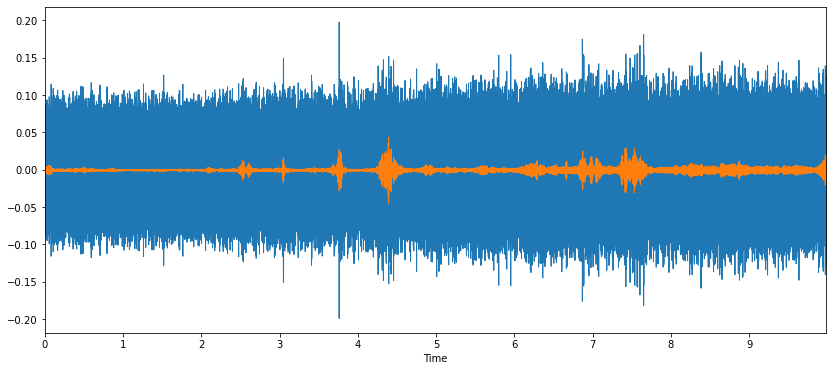

In [24]:
librosa.display.waveplot(y1,sr=sr, x_axis='time');
librosa.display.waveplot(yg1,sr=sr, x_axis='time');

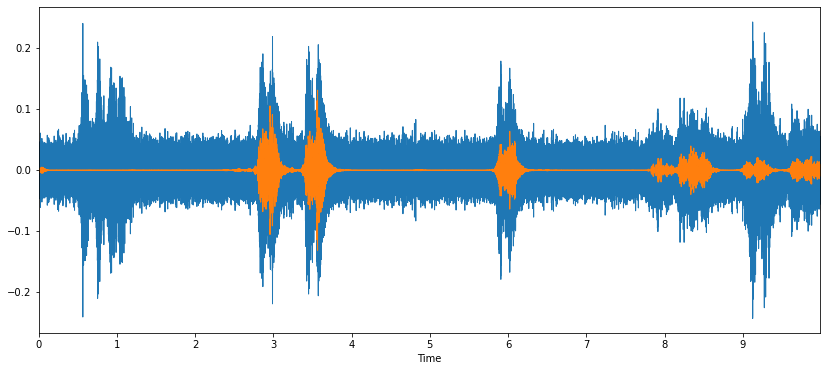

In [25]:
librosa.display.waveplot(y2,sr=sr, x_axis='time');
librosa.display.waveplot(yg2,sr=sr, x_axis='time');

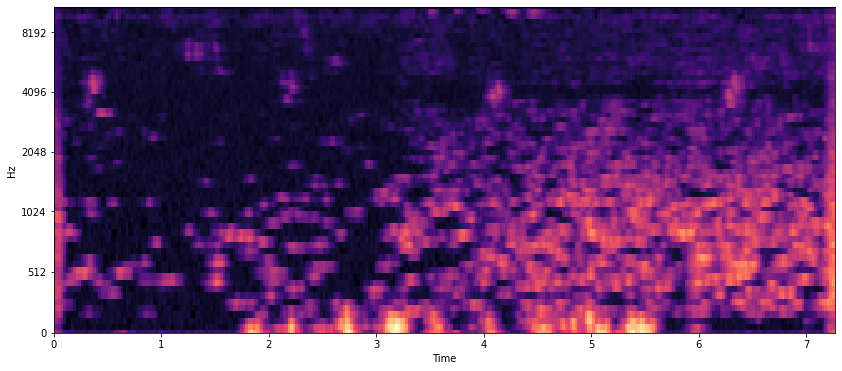

In [26]:
Sg1 = librosa.feature.melspectrogram(y=yg1, sr=sr, n_mels=64)
Dg1 = librosa.power_to_db(Sg1, ref=np.max)
librosa.display.specshow(Dg1, x_axis='time', y_axis='mel');

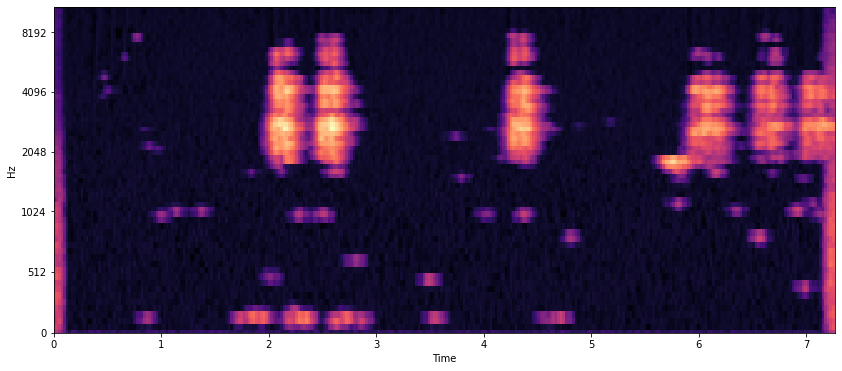

In [27]:
Sg2 = librosa.feature.melspectrogram(y=yg2, sr=sr, n_mels=64)
Dg2 = librosa.power_to_db(Sg2, ref=np.max)
librosa.display.specshow(Dg2, x_axis='time', y_axis='mel');

In [28]:
display(Audio(yg1,rate=sr))
display(Audio(yg2,rate=sr))

It didn't work so well on the noisy sound, but it was very good on the high SNR sample. Maybe some parameters can be adjusted to improve the results.

# Combining the methods

Yes, I know what you are thinking. What if I combine these methods? From this code it is very easy to do such tests.

Also, there are lots of parameter to try!

It is up to you.

# Impact on training and classification

I am still testing these preprocessing methods on my models.

By now, I have a very initial model here: https://www.kaggle.com/mauriciofigueiredo/intro-to-filtering-process-model-submitting

As you can see, it is a very basic model based on KNN over mfcc features. I combined some of the above strategies and applied on a subset of bird classes. The accuracy increase was around 10% over a split of  the selected data.